## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(10)
        cv2.destroyAllWindows()
print("Done")

Done


## Calibration

In [1]:
import scripts.distortion as dis

In [2]:
mtx, dist = dis.calibrate()

In [2]:
# Calibraton of camera
img = cv2.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

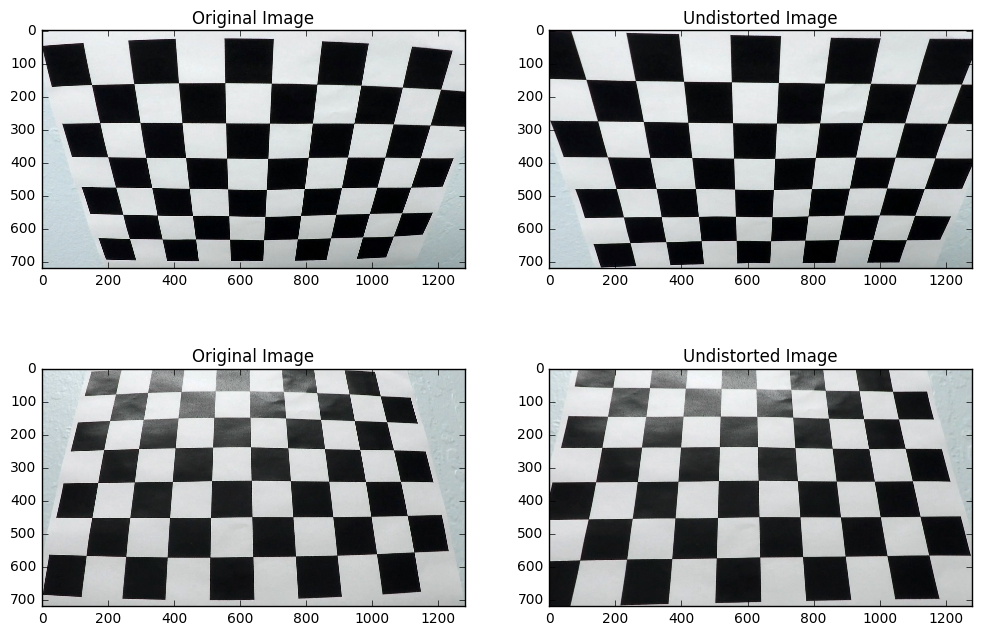

In [5]:
#Examples of undistorted image
%matplotlib inline
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

img = cv2.imread("camera_cal/calibration2.jpg")
ax[0][0].set_title('Original Image')
ax[0][0].imshow(img)
img2 = cv2.undistort(img, mtx, dist, None, mtx)
ax[0][1].set_title('Undistorted Image')
ax[0][1].imshow(img2)

img3 = cv2.imread("camera_cal/calibration3.jpg")
ax[1][0].set_title('Original Image')
ax[1][0].imshow(img3)
img4 = cv2.undistort(img3, mtx, dist, None, mtx)
ax[1][1].set_title('Undistorted Image')
ax[1][1].imshow(img4)

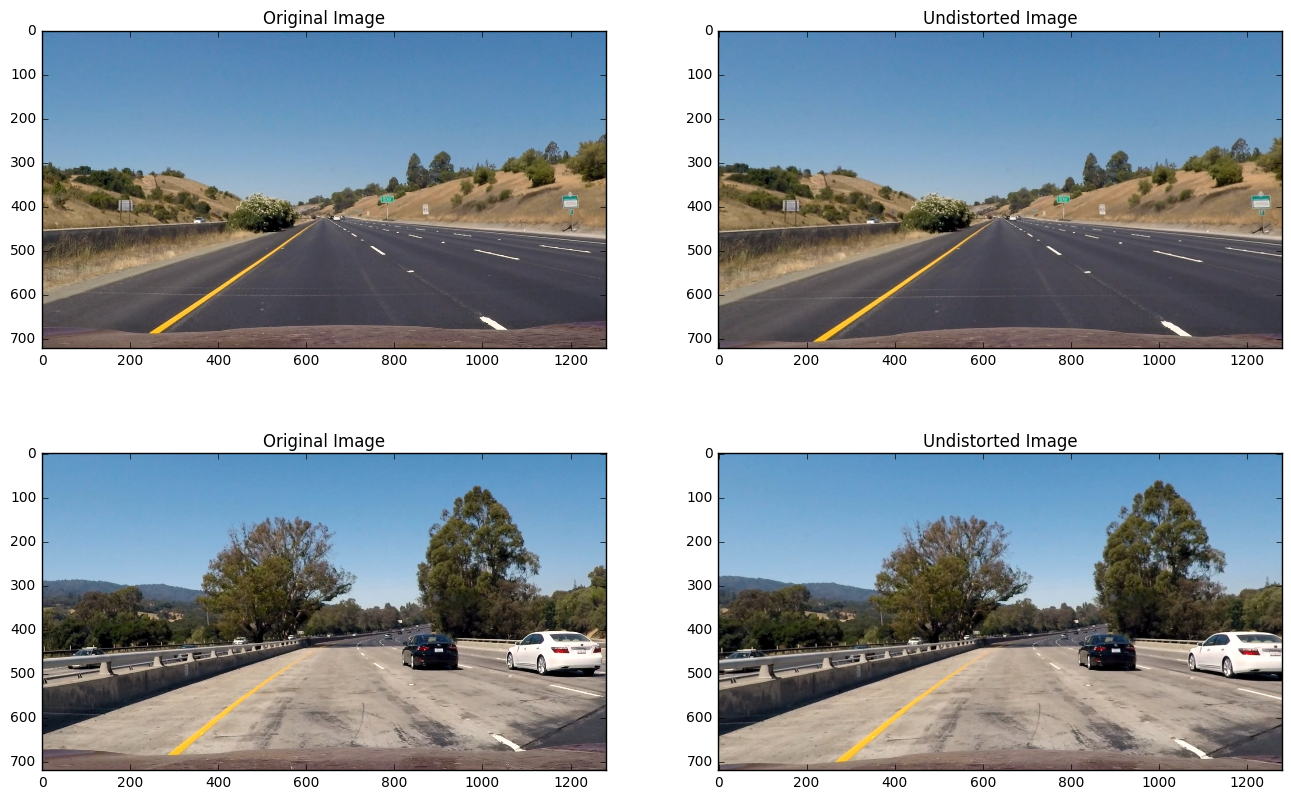

In [4]:
# Using camera mtx on road images
%matplotlib inline
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

# BGR2RGB
img = cv2.cvtColor(cv2.imread("test_images/straight_lines1.jpg"), cv2.COLOR_BGR2RGB)
ax[0][0].set_title('Original Image')
ax[0][0].imshow(img)
img2 = cv2.undistort(img, mtx, dist, None, mtx)
ax[0][1].set_title('Undistorted Image')
ax[0][1].imshow(img2)

# BGR2RGB
img3 = cv2.cvtColor(cv2.imread("test_images/test1.jpg"), cv2.COLOR_BGR2RGB)
ax[1][0].set_title('Original Image')
ax[1][0].imshow(img3)
img4 = cv2.undistort(img3, mtx, dist, None, mtx)
ax[1][1].set_title('Undistorted Image')
ax[1][1].imshow(img4)

## Color & Gradient Threshold

In [5]:
import scripts.extraction as ext
test_file = 'test_images/test1.jpg'
image = mpimg.imread(test_file)
hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

h_channel = hls_image[:, :, 0]
s_channel = hls_image[:, :, 2]

In [6]:
hue_image = ext.hue(h_channel)
saturation_image = ext.saturation(s_channel)
ksize = 3
gradx = ext.abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(60, 130))
grady = ext.abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(60, 130))

mag_binary = ext.mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 100))

dir_binary = ext.dir_threshold(image, sobel_kernel=27, thresh=(0.7, 1.3))

gradients_combined = np.zeros_like(dir_binary)
gradients_combined[((gradx == 1) & (grady == 1) & (dir_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

combined = np.zeros_like(saturation_image)
combined[(hue_image == 1) & (saturation_image ==1) | (gradients_combined==1)] =1

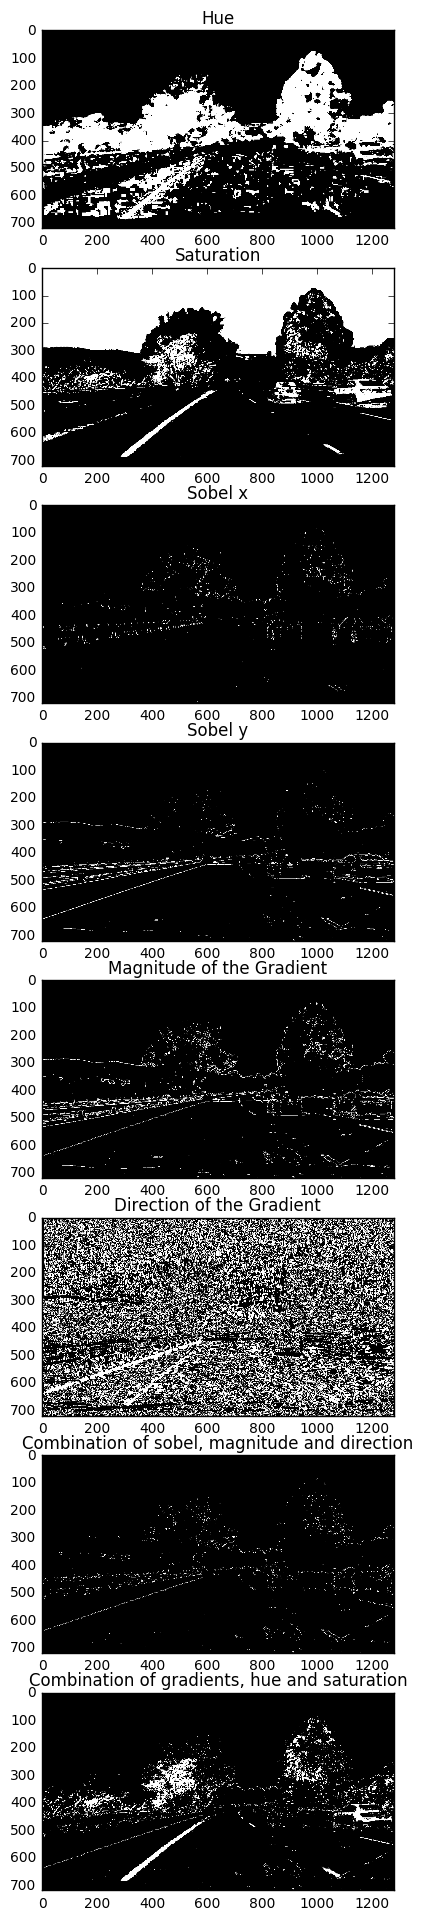

In [7]:
%matplotlib inline
f, ax = plt.subplots(ncols=1, nrows=8, figsize=(24,24))

# BGR2RGB

ax[0].set_title('Hue')
ax[0].imshow(hue_image, cmap='gray')
ax[1].set_title('Saturation')
ax[1].imshow(saturation_image, cmap='gray')
ax[2].set_title('Sobel x')
ax[2].imshow(gradx, cmap='gray')
ax[3].set_title('Sobel y')
ax[3].imshow(grady, cmap='gray')
ax[4].set_title('Magnitude of the Gradient')
ax[4].imshow(mag_binary, cmap='gray')
ax[5].set_title('Direction of the Gradient')
ax[5].imshow(dir_binary, cmap='gray')
ax[6].set_title('Combination of sobel, magnitude and direction')
ax[6].imshow(gradients_combined, cmap='gray')
ax[7].set_title('Combination of gradients, hue and saturation')
ax[7].imshow(combined, cmap='gray')


## Region of interest

In [8]:
import scripts.region_of_interest as rog

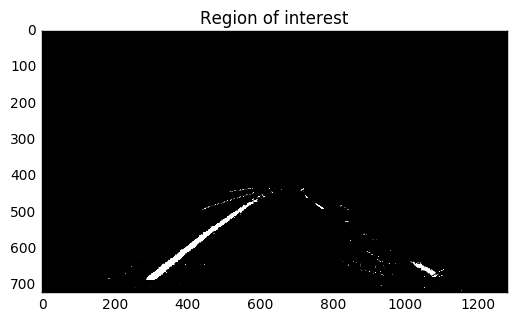

In [9]:
combined = ext.extract(image)
region_image = rog.region_of_interest(combined)
plt.figure()
plt.title('Region of interest')
plt.imshow(region_image)

## Perspective Transform

In [10]:
import scripts.perspective as per
import scripts.sliding as sli

### Birds View

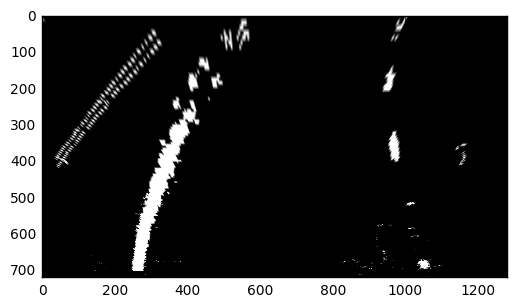

In [11]:
transformed = region_image[:,:,0].flatten().reshape(-1,1280)
birds_view_image = per.birds_view(transformed)
plt.imshow(birds_view_image, cmap='gray')

In [12]:
Minv = per.get_matrix_for_brids_view_to_3d()

In [13]:
result, birds_view_image, ploty, left_fit, right_fit, leftx, rightx, lefty, righty = sli.slide(birds_view_image, Minv, undist=image)

/Users/nixoxo/Code/Self_Driving_Cars/Term_1/CarND-Advanced-Lane-Lines/scripts/sliding.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(img[img.shape[0]/2:,:], axis=0)


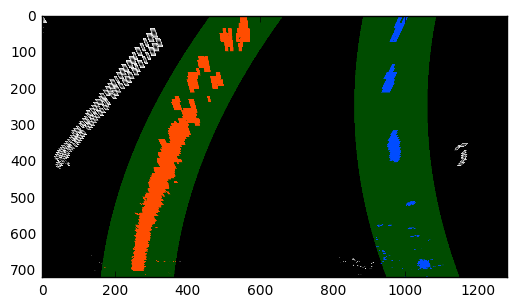

In [14]:
plt.imshow(birds_view_image, cmap='gray')

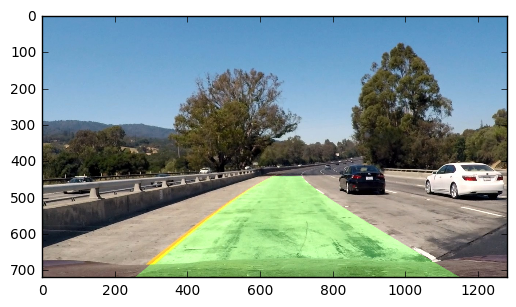

In [15]:
plt.imshow(result)

## Sticking it together

In [16]:
import pipeline as pipe

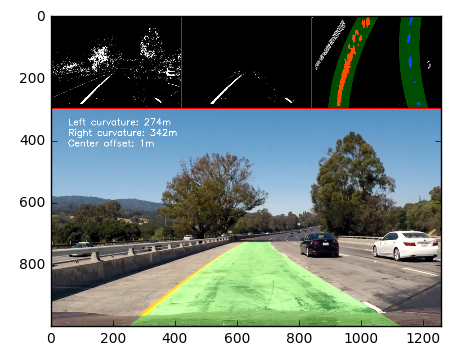

In [17]:
orig_img = plt.imread(test_file)
plt.imshow(pipe.pipeline(orig_img))

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(img):
    return pipe.pipeline(img)

In [21]:
project_output = 'project_video_advanced.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_advanced.mp4
[MoviePy] Writing video project_video_advanced.mp4


100%|█████████▉| 1260/1261 [04:57<00:00,  4.29it/s]    | 1/1261 [00:00<05:11,  4.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_advanced.mp4 

CPU times: user 4min 44s, sys: 1min 7s, total: 5min 52s
Wall time: 4min 58s


In [22]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(project_output))